In [1]:
import platform 
operating_system = platform.system()
print(operating_system)

Linux


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import concurrent.futures as cf
%matplotlib inline

import sys
sys.path.insert(0, "/home/dotson/research/cairo")
if operating_system is 'Linux':
    sys.path.insert(0, "/home/dotson/research/cairo")
    
elif operating_system is 'Windows':
    sys.path.insert(0, "C:/users/samgd/research/cairo")


# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from tools import update_params
from optimizers import grid_optimizer_parallel, grid_optimizer
from sunrise import generate_elevation_series
from pyESN.pyESN import ESN

In [3]:
# import demand data
dataframe = pd.read_csv("../data/uiuc_demand_data.csv", usecols=['time','kw'])
demand = np.array(dataframe.kw).astype('float64')

# normalize
norm = np.linalg.norm(demand)
demand_norm = demand/norm

In [4]:
time_range = pd.date_range(start='1/1/2015', end='7/1/2019', freq='h')[:-2]
elevation = generate_elevation_series(time_range, timestamps=True)
norm_a = np.linalg.norm(elevation)
angles_norm = elevation/norm_a
print(f"Norm of elevation angles: {norm_a}")
print(f"Norm of demand: {norm}")

Norm of elevation angles: 7170.040655802196
Norm of demand: 10142199.043147163


In [5]:
X_in = np.concatenate([[demand_norm, angles_norm]], axis=1)
    
print(f"Shape of X_in is {X_in.shape}")

Shape of X_in is (2, 39407)


In [6]:
# optimal parameters from demand-windowsize
params = {'n_reservoir':100, 
          'sparsity':0.03, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':1, 
          'trainlen':500}

rand_seeds = np.random.rand(150)*10000
rand_seeds = rand_seeds.astype(int)
# rand_seeds = [85, 232,12, 33, 45, 19, 29, 402, 222, 13139, 
#               234, 512, 2993, 1, 90, 44, 30, 901, 444, 666, 69]
print(rand_seeds)
params_list = [update_params(x, 'rand_seed', params) for x in rand_seeds]

[ 800 6317 1997 9297 5414 7804 7179 4250 3548 9395 5344 3109 6120 4977
 9572 4503 3873 7337 9000 2982 4092 2995 7572 7340 6525 1801 2978 4241
 1780 9055 2744 8189 6638 7417 9720  534 8965 3025 8876 9242  488 1276
 8217 8026 7135 2835 2588 6221 3568 2002 3407 2713 7356 3183 5777 9465
 5701 7738 4410 6329 2854 4508 4129 2066 8752 3566 5754 2166 8271  907
 1788 7044 9135 3523  548 6765 4645 9889 9544 9538 7440 7236 9740 4880
 7498 2198 9224 4532 4895  502  380 5977 2069 8527 4899 5817  793  387
 2150 1178 5880 8294 8992 9624 8740 5448  535 5749   56  486 1843 1200
 9800 9922  761 9018 8884 9566 8160 8758 1169 5526 3993 4019 7129 9066
 1549 8068 4633 5871  631 6040 7566 5167 2906  236 2407 2528 4087 2631
 6056 6440 6033 3801 6527 9667 3960  144 9345 8659]


In [7]:
futureTotal = params['future']
time_range = np.array(dataframe.time)
hour_range = np.arange(0, len(time_range), 1)

In [8]:
N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
#     print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
    
mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 115.47 seconds
This simulation took 1.92 minutes


In [9]:
N = len(rand_seeds)
Npredictions = np.ones((N, futureTotal))
x_train = np.array([X_in.T for i in rand_seeds])

tic = time.perf_counter()

with cf.ProcessPoolExecutor(max_workers=10) as executor:
    results = executor.map(esn_prediction, x_train, params_list)
    
    for i, result in enumerate(results):
        Npredictions[i] = result.T[0]
    
parallel_mean_prediction = np.mean(Npredictions, axis=0)
parallel_std_prediction = np.std(Npredictions, axis=0)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 186.79 seconds
This simulation took 3.11 minutes


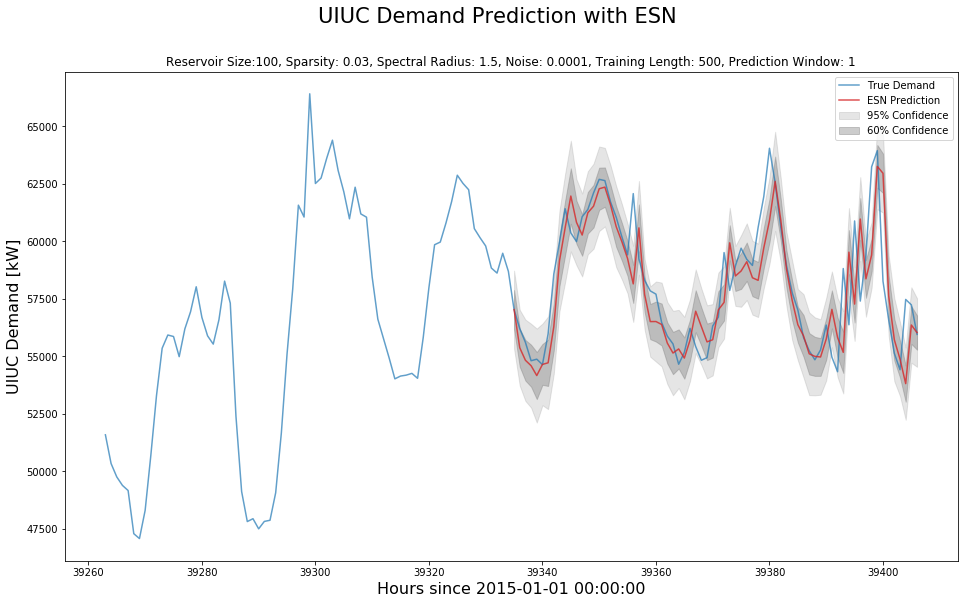

In [10]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

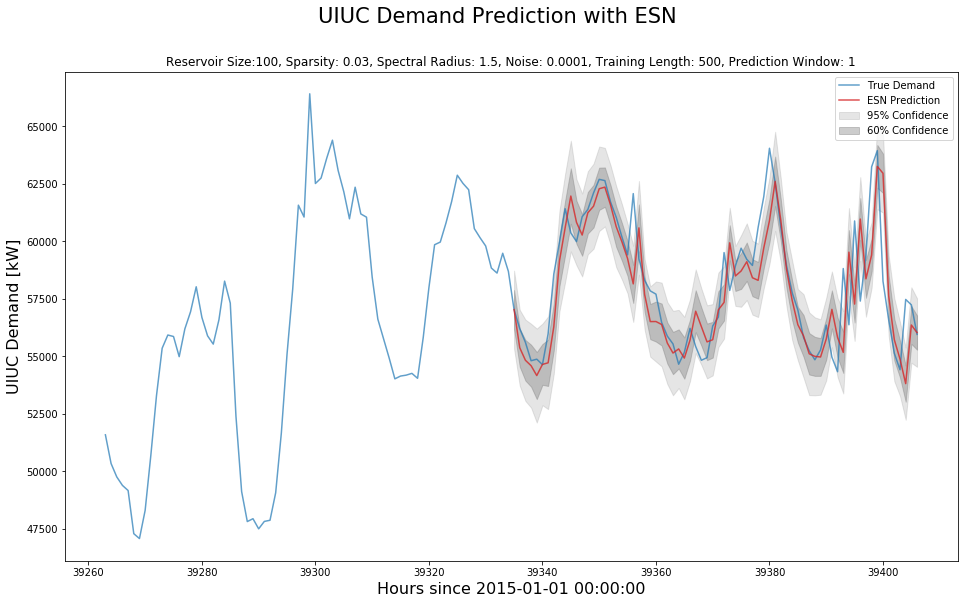

In [11]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*parallel_mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(parallel_mean_prediction + 2 * parallel_std_prediction),
                 norm*(parallel_mean_prediction - 2 * parallel_std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(parallel_mean_prediction + parallel_std_prediction),
                 norm*(parallel_mean_prediction - parallel_std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

In [12]:
# tic = time.perf_counter()
# trainingLengths = np.arange(200,1000,2)
# trainlen_loss = grid_optimizer_parallel(X_in.T,
#                       params,
#                       args=['trainlen'],
#                       xset=trainingLengths,
#                       verbose=True,
#                       visualize=True)

# toc = time.perf_counter()
# elapsed = toc - tic
# print(f"This simulation took {elapsed:0.02f} seconds") 
# print(f"This simulation took {elapsed/60:0.02f} minutes")

In [13]:
# tic = time.perf_counter()
# trainingLengths = np.arange(200,1000,2)
# trainlen_loss = grid_optimizer(X_in.T,
#                       params,
#                       args=['trainlen'],
#                       xset=trainingLengths,
#                       verbose=True,
#                       visualize=True)

# toc = time.perf_counter()
# elapsed = toc - tic
# print(f"This simulation took {elapsed:0.02f} seconds") 
# print(f"This simulation took {elapsed/60:0.02f} minutes")